## We have divided the problem into two parts
(a) Predict the floor number
(b) Predict the way points or location on that floor

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
from pathlib import Path
pd.options.mode.chained_assignment = None  # default='warn'
from dataclasses import dataclass
from sklearn import preprocessing

In [ ]:
import keras
from keras.utils import to_categorical
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Bidirectional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Function to connect waypoint coordinates with straight lines
#This will be used for second part of project.We will discuss about this later.
def connect_waypoints(wp_df):
  if(wp_df.at[0,'waypoint_val1']==''):
    wp_df.at[0,'waypoint_val1']=0
  if(wp_df.at[0,'waypoint_val2']==''):
    wp_df.at[0,'waypoint_val2']=0  
  j=0
  i=0
  last=0
  #print(wp_df.head(5))
  while i < (len(wp_df)-1):
    j=i+1
    while((wp_df.at[j,'waypoint_val1']==0) and (wp_df.at[j,'waypoint_val2']==0) ):
      if(j==len(wp_df)-1):
        wp_df.at[j,'waypoint_val1']=wp_df.at[i,'waypoint_val1']
        wp_df.at[j,'waypoint_val2']=wp_df.at[i,'waypoint_val2']
        last=1
        break
      j+=1
    temp_arrayx=np.linspace(wp_df.at[i,'waypoint_val1'],wp_df.at[j,'waypoint_val1'], num=j-i+1)
    temp_arrayy=np.linspace(wp_df.at[i,'waypoint_val2'],wp_df.at[j,'waypoint_val2'], num=j-i+1)
    #print(temp_arrayx)
    m=0
    for k in range(i,j+1):
      wp_df.at[k,'waypoint_val1']=temp_arrayx[m]
      wp_df.at[k,'waypoint_val2']=temp_arrayy[m]
      #For final comparison of our predicted location, we will need to mark which waypoints were in original data before connecting them
      #print('k=',k,'i=',i,'j=',j)
      if((k==i) and (last==0)):
        wp_df.at[k,'interpolated']=1 #original waypoints
      else:
        wp_df.at[k,'interpolated']=0  #interpolated waypoints
      m+=1
    i=j
  return wp_df     


In [ ]:
# Function to extract arrays for each sensor with timeslots.
# This particular function is modified from the function provided by the competition's github page at https://github.com/location-competition/indoor-location-competition-20/blob/master/io_f.py

@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []
    line_count=0
    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        #line_count=line_count+1
        #if(line_count>3000):
        #  break
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = int(line_data[0])
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = int(line_data[0])
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    acce = np.array(acce,dtype=np.float)
    acce_uncali = np.array(acce_uncali,dtype=np.float)
    gyro = np.array(gyro,dtype=np.float)
    gyro_uncali = np.array(gyro_uncali,dtype=np.float)
    magn = np.array(magn,dtype=np.float)
    magn_uncali = np.array(magn_uncali,dtype=np.float)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

In [ ]:
#Function to go through all the files in the folder and return the sensor data 
# in the form of arrays
@dataclass
class trace:
    sequence: np.ndarray
    target_seq: np.ndarray
    waypoint_seq: np.ndarray
    wp_full_seq: np.ndarray

def convert_to_df(file_path,floor,timeslots):
    pathlist = Path(file_path).rglob('*.txt')
    sequence = list()
    target_seq=list()
    waypoint_seq=list()
    wp_full_seq=list()
    path_id=1
    floor_trace_df=pd.DataFrame()
    for path in pathlist:
         # because path is object not string
        path_in_str = str(path)
         # print(path_in_str)
        trace_file = read_data_file(path_in_str)
        trace_df=pd.DataFrame()
        if(trace_file.acce.size):
            acce_df=pd.DataFrame(trace_file.acce, columns=['Timestamp','acce_val1','acce_val2','acce_val3'])
        if(trace_file.acce_uncali.size):
            acce__uncal_df=pd.DataFrame(trace_file.acce_uncali, columns=['Timestamp','acce_uncal_val1','acce_uncal_val2','acce_uncal_val3'])   
        if(trace_file.gyro.size):
            gyro_df=pd.DataFrame(trace_file.gyro, columns=['Timestamp','gyro_val1','gyro_val2','gyro_val3'])
        if(trace_file.gyro_uncali.size):
            gyro_uncal_df=pd.DataFrame(trace_file.gyro_uncali, columns=['Timestamp','gyro_uncal_val1','gyro_uncal_val2','gyro_uncal_val3'])
        if(trace_file.magn.size):
            magn_df=pd.DataFrame(trace_file.magn, columns=['Timestamp','magn_val1','magn_val2','magn_val3'])
        if(trace_file.magn_uncali.size):
            magn_uncal_df=pd.DataFrame(trace_file.magn_uncali, columns=['Timestamp','magn_uncal_val1','magn_uncal_val2','magn_uncal_val3'])
        if(trace_file.ahrs.size):
            rot_df=pd.DataFrame(trace_file.ahrs, columns=['Timestamp','rot_val1','rot_val2','rot_val3'])           
        if(trace_file.wifi.size):
            wifi_df=pd.DataFrame(trace_file.wifi, columns=['Timestamp','wifi_val1','wifi_val2','wifi_val3','wifi_val4']) 
        if(trace_file.ibeacon.size):
            ibeacon_df=pd.DataFrame(trace_file.ibeacon, columns=['Timestamp','ibeacon_val1','ibeacon_val2'])    
        if(trace_file.waypoint.size):
            waypoint_df=pd.DataFrame(trace_file.waypoint, columns=['Timestamp','waypoint_val1','waypoint_val2'])
        
        #change data type of wifi dataframe timestamp and ibeacon timestamp
        wifi_df["Timestamp"] = wifi_df.Timestamp.astype(float)
        ibeacon_df["Timestamp"] = ibeacon_df.Timestamp.astype(float)
        trace_df = pd.merge(acce_df, acce__uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, gyro_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, gyro_uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, magn_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, magn_uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, rot_df, on='Timestamp', how='outer')
        #trace_df = pd.merge(trace_df, wifi_df, on='Timestamp', how='outer')
        #trace_df = pd.merge(trace_df, ibeacon_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, waypoint_df, on='Timestamp', how='outer')
        ###### Cast time stamp to integer
        trace_df["Timestamp"] = trace_df.Timestamp.astype(int)

        # sorting by Timestamp and deleting duplicate timeslots 
        
        trace_df.sort_values("Timestamp", inplace = True)
        trace_df = trace_df.reset_index(drop=True)
        trace_df.drop_duplicates(subset="Timestamp",keep=False, inplace=True)
        trace_df = trace_df.reset_index(drop=True)
        
        trace_df=trace_df.replace(np.nan,0)

        #keep only top 200 rows in one sequence     
        #trace_df=trace_df.head(200)

        #for i in range(0,len(trace_df)):
         # trace_df.at[i,'Timestamp']=i
        
        #trace_df['time_index'] = trace_df.index
        #print(trace_df.head())
        #trace_df['floor_name']=floor
        #trace_df['path_id']=floor+path_id
        #path_id=path_id+1
        #trace_df['wifi_df'].fillna(0)
        #trace_df['ibeacon_df'].fillna(0)
        #trace_df['wifi_df'].fillna(0)
        

        wp_df = trace_df[['waypoint_val1', 'waypoint_val2']].copy()
        wp_df=connect_waypoints(wp_df)
        wp_values=wp_df.values
        #Removing text based fields in dataframe
        trace_df=trace_df.drop(['Timestamp'], axis=1)
        #trace_df=trace_df.drop(['wifi_val1'], axis=1)
        #trace_df=trace_df.drop(['wifi_val2'], axis=1)
        #trace_df=trace_df.drop(['ibeacon_val1'], axis=1)
        trace_df.astype('float32')        
        trace_df=trace_df.drop(['waypoint_val1','waypoint_val2'], axis=1)
        #floor_trace_df=floor_trace_df.append(trace_df)
        values = trace_df.values 


        


        #Now split sequence into required number of timeslots
        l=int(len(values)/timeslots)
        k=0
        for m in range(l):
          s_temp=values[k:k+timeslots]
          wp_temp=wp_values[k:k+timeslots]
          #Normalize
          #min_max_scaler = preprocessing.MinMaxScaler()
          #s_scaled = min_max_scaler.fit_transform(s_temp)
          sequence.append(s_temp)
          wp_full_seq.append(wp_temp)
          target_seq.append(floor)
          wp_temp=wp_df.iloc[k:k+timeslots,0:]
          wp_temp=wp_temp.reset_index(drop=True)
          #wp_temp=connect_waypoints(wp_temp)
        #Now after connecting the waypoints, the avearge has become a wieghted average in time series
          wp_avg_x=wp_temp['waypoint_val1'].mean()
          wp_avg_y=wp_temp['waypoint_val2'].mean()
        #maximum and minimum will be useful in second part
          wp_max_x=wp_temp['waypoint_val1'].max()
          wp_min_x=wp_temp['waypoint_val1'].min()
          wp_max_y=wp_temp['waypoint_val2'].max()
          wp_min_y=wp_temp['waypoint_val2'].min()
          
          waypoint_seq.append([wp_avg_x,wp_avg_y,wp_max_x,wp_min_x,wp_max_y,wp_min_y])
          k+=timeslots

    return trace(sequence,target_seq,waypoint_seq,wp_full_seq)

In [ ]:
#Extracting data for B1 floor only
sequences = list()
target_sequence=list()
waypoint_sequence=list()
waypoint_full_sequence=list()
#floors_df=pd.DataFrame()
file_path = '/content/drive/MyDrive/building1/data/B1'
trace_values=(convert_to_df(file_path,0,5))
sequences.extend(trace_values.sequence)
target_sequence.extend(trace_values.target_seq)
waypoint_sequence.extend(trace_values.waypoint_seq)
waypoint_full_sequence.extend(trace_values.wp_full_seq)

In [ ]:
len(waypoint_sequence)

38874

In [ ]:
len(sequences[0])

5

In [ ]:
print('Number of sequences',len(sequences))
print('Number of targets',len(target_sequence))
print('Number of timeslots in first sequence',(sequences[0].shape)[0])
print('Number of timeslots in tenth sequence',(sequences[9].shape)[0])
print('Number of timeslots in hundredth sequence',(sequences[99].shape)[0])

Number of sequences 38874
Number of targets 38874
Number of timeslots in first sequence 5
Number of timeslots in tenth sequence 5
Number of timeslots in hundredth sequence 5


# Part 2 

### After knowing the floor, now we need to predict waypoints on that floor.

### We assume that floor B1 was predicted in first part. So, for this part we will only take data of floor B1.

In [ ]:
len(waypoint_sequence)

38874

In [ ]:
len(sequences)

38874

In [ ]:
##We will divide the area into grids. But first we need to know the dimensions to work with
wp_df = pd.DataFrame(waypoint_sequence, columns = ['avg_x','avg_y','max_x','min_x','max_y','min_y',])
wp_df=wp_df.head(len(sequences))  #number of sequences for floor B1
wp_df = wp_df.round(decimals=5)
floor_max_x=wp_df['max_x'].max()
floor_min_x=wp_df['min_x'].min()
floor_max_y=wp_df['max_y'].max()
floor_min_y=wp_df['min_y'].min()
print(floor_max_x,floor_min_x,floor_max_y,floor_min_y)

233.94418 36.63454 192.99721 75.00506


In [ ]:
#Creating grid for labelling
#We will create a 10X10 grid for 100 labels
array_x=np.linspace(floor_min_x,floor_max_x,11)
array_y=np.linspace(floor_min_y,floor_max_y,11)
label=list()
k=0
for j in range(1,11):
  for i in range(1,11):
    label.append([array_x[i],array_y[j],k])
    k+=1  

In [ ]:
#Now we need to give labels to our waypoints sequence on the basis of average waypoints
print(wp_df.head())
for i in range(len(wp_df)):
  for j in range(len(label)):
    if(wp_df.at[i,'avg_x']<=label[j][0]):
       for p in range(len(label)):
         if(wp_df.at[i,'avg_y']<=label[p][1]):
           wp_df.at[i,'label']=label[j+p][2]
           break
       break    
print(wp_df.head(20))           

       avg_x      avg_y      max_x      min_x      max_y      min_y
0  198.39960  163.51350  198.43087  198.36833  163.52063  163.50637
1  198.47778  163.49568  198.50905  198.44651  163.50281  163.48855
2  198.55596  163.47785  198.58723  198.52469  163.48498  163.47072
3  198.63414  163.46003  198.66541  198.60287  163.46716  163.45290
4  198.71232  163.44220  198.74359  198.68105  163.44933  163.43507
        avg_x      avg_y      max_x      min_x      max_y      min_y  label
0   198.39960  163.51350  198.43087  198.36833  163.52063  163.50637   78.0
1   198.47778  163.49568  198.50905  198.44651  163.50281  163.48855   78.0
2   198.55596  163.47785  198.58723  198.52469  163.48498  163.47072   78.0
3   198.63414  163.46003  198.66541  198.60287  163.46716  163.45290   78.0
4   198.71232  163.44220  198.74359  198.68105  163.44933  163.43507   78.0
5   198.79050  163.42438  198.82177  198.75923  163.43151  163.41725   78.0
6   198.86868  163.40656  198.89995  198.83741  163.41369  1

In [ ]:
#Now we need to create new train, validation and test split for only building 1
train_length=int(len(sequences)*0.7)
val_length=int(len(sequences)*0.15)
test_length=len(sequences)-train_length-val_length

train_flags=np.full((train_length), 0)
validation_flags=np.full((val_length), 1)
test_flags=np.full((test_length), 2)

flags=[]
flags.extend(train_flags)
flags.extend(validation_flags)
flags.extend(test_flags)
np.random.shuffle(flags)
len(flags)

38874

In [ ]:
#Creating target sequence
target_sequence2=wp_df['label'].values
#Slice the sequence to get only floor B1 data
sequences2=sequences[0:len(sequences)]
target_sequence2=np.array(target_sequence2)
target_sequence2

array([78., 78., 78., ..., 73., 73., 73.])

In [ ]:
train = [sequences2[i] for i in range(len(flags)) if (flags[i]==0)]
validation = [sequences2[i] for i in range(len(flags)) if flags[i]==1]
test = [sequences2[i] for i in range(len(flags)) if flags[i]==2]
test_seq_wp=[waypoint_full_sequence[i] for i in range(len(flags)) if flags[i]==2]

train_target = [target_sequence2[i] for i in range(len(flags)) if (flags[i]==0)]
validation_target = [target_sequence2[i] for i in range(len(flags)) if flags[i]==1]
test_target = [target_sequence2[i] for i in range(len(flags)) if flags[i]==2]
train = np.array(train)
validation = np.array(validation)
test = np.array(test)

train_target = np.array(train_target)
train_target=to_categorical(train_target,num_classes = 100)

validation_target = np.array(validation_target)
validation_target=to_categorical(validation_target,num_classes = 100)
test_target = np.array(test_target)
test_target=to_categorical(test_target,num_classes = 100)

In [ ]:
print(sequences2[0].shape)
train_target[0]
len(test_seq_wp)

(5, 21)


5832

In [ ]:
train=tf.convert_to_tensor(train, np.float32)
train_target=tf.convert_to_tensor(train_target, np.float32)
validation=tf.convert_to_tensor(validation, np.float32)
validation_target=tf.convert_to_tensor(validation_target, np.float32)
test=tf.convert_to_tensor(test, np.float32)
test_target=tf.convert_to_tensor(test_target, np.float32)

In [ ]:
#Trial with 100 grid cells 
from keras.layers import Dropout
seq_len = 5
seq_bredth=21
model = Sequential()
model.add(Bidirectional(LSTM(256,return_sequences=True),input_shape=(seq_len, seq_bredth),merge_mode='concat'))
model.add(Dropout(0.2))
model.add(LSTM(256, input_shape=(3, 512)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 512)            569344    
_________________________________________________________________
dropout (Dropout)            (None, 5, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1

In [ ]:
#This is 100 cells simple LSTM
adam = Adam(lr=0.001)
checkpoint_filepath = '/content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl'
chk = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model.fit(train, train_target, epochs=200, batch_size=128, callbacks=[chk], validation_data=(validation,validation_target))

Epoch 1/200
213/213 [==============================] - 29s 117ms/step - loss: 3.5363 - accuracy: 0.1047 - val_loss: 2.2777 - val_accuracy: 0.2960

Epoch 00001: val_accuracy improved from -inf to 0.29600, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 2/200
213/213 [==============================] - 23s 109ms/step - loss: 2.2534 - accuracy: 0.2728 - val_loss: 1.8162 - val_accuracy: 0.3758

Epoch 00002: val_accuracy improved from 0.29600 to 0.37575, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 3/200
213/213 [==============================] - 24s 112ms/step - loss: 1.9286 - accuracy: 0.3440 - val_loss: 1.5901 - val_accuracy: 0.4399

Epoch 00003: val_accuracy improved from 0.37575 to 0.43989, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 4/200
213/213 [==============================] - 24s 111ms/step - loss: 1.6833 - accuracy: 0.4089 - val_loss: 1.7819 - val_accuracy: 0.3857

Epoch 00004: val_accuracy did not improve from 0.43989
Epoch 5/200
213/213 [==============================] - 24s 112ms/step - loss: 1.6024 - accuracy: 0.4370 - val_loss: 1.3975 - val_accuracy: 0.4896

Epoch 00005: val_accuracy improved from 0.43989 to 0.48962, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 6/200
213/213 [==============================] - 23s 110ms/step - loss: 1.4837 - accuracy: 0.4636 - val_loss: 1.3698 - val_accuracy: 0.4968

Epoch 00006: val_accuracy improved from 0.48962 to 0.49683, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 7/200
213/213 [==============================] - 24s 112ms/step - loss: 1.4878 - accuracy: 0.4741 - val_loss: 1.2577 - val_accuracy: 0.5340

Epoch 00007: val_accuracy improved from 0.49683 to 0.53404, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 8/200
213/213 [==============================] - 24s 112ms/step - loss: 1.3461 - accuracy: 0.5116 - val_loss: 1.3496 - val_accuracy: 0.4994

Epoch 00008: val_accuracy did not improve from 0.53404
Epoch 9/200
213/213 [==============================] - 24s 114ms/step - loss: 1.4060 - accuracy: 0.4947 - val_loss: 1.2504 - val_accuracy: 0.5440

Epoch 00009: val_accuracy improved from 0.53404 to 0.54399, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 10/200
213/213 [==============================] - 24s 112ms/step - loss: 1.2726 - accuracy: 0.5376 - val_loss: 1.1690 - val_accuracy: 0.5707

Epoch 00010: val_accuracy improved from 0.54399 to 0.57074, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 11/200
213/213 [==============================] - 24s 111ms/step - loss: 1.2077 - accuracy: 0.5575 - val_loss: 1.1823 - val_accuracy: 0.5558

Epoch 00011: val_accuracy did not improve from 0.57074
Epoch 12/200
213/213 [==============================] - 23s 110ms/step - loss: 1.1726 - accuracy: 0.5723 - val_loss: 1.2703 - val_accuracy: 0.5421

Epoch 00012: val_accuracy did not improve from 0.57074
Epoch 13/200
213/213 [==============================] - 23s 109ms/step - loss: 1.1588 - accuracy: 0.5735 - val_loss: 1.0218 - val_accuracy: 0.6191

Epoch 00013: val_accuracy improved from 0.57074 to 0.61910, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 14/200
213/213 [==============================] - 24s 113ms/step - loss: 1.3021 - accuracy: 0.5510 - val_loss: 1.0320 - val_accuracy: 0.6275

Epoch 00014: val_accuracy improved from 0.61910 to 0.62751, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 15/200
213/213 [==============================] - 24s 113ms/step - loss: 1.1009 - accuracy: 0.5947 - val_loss: 1.0137 - val_accuracy: 0.6218

Epoch 00015: val_accuracy did not improve from 0.62751
Epoch 16/200
213/213 [==============================] - 24s 112ms/step - loss: 1.0695 - accuracy: 0.6075 - val_loss: 1.0037 - val_accuracy: 0.6263

Epoch 00016: val_accuracy did not improve from 0.62751
Epoch 17/200
213/213 [==============================] - 24s 111ms/step - loss: 1.0629 - accuracy: 0.6138 - val_loss: 0.9425 - val_accuracy: 0.6443

Epoch 00017: val_accuracy improved from 0.62751 to 0.64431, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 18/200
213/213 [==============================] - 24s 113ms/step - loss: 1.0320 - accuracy: 0.6172 - val_loss: 0.9369 - val_accuracy: 0.6448

Epoch 00018: val_accuracy improved from 0.64431 to 0.64483, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 19/200
213/213 [==============================] - 24s 112ms/step - loss: 0.9698 - accuracy: 0.6401 - val_loss: 1.0826 - val_accuracy: 0.6056

Epoch 00019: val_accuracy did not improve from 0.64483
Epoch 20/200
213/213 [==============================] - 24s 112ms/step - loss: 0.9692 - accuracy: 0.6400 - val_loss: 1.0890 - val_accuracy: 0.6141

Epoch 00020: val_accuracy did not improve from 0.64483
Epoch 21/200
213/213 [==============================] - 24s 112ms/step - loss: 1.0424 - accuracy: 0.6258 - val_loss: 0.9246 - val_accuracy: 0.6544

Epoch 00021: val_accuracy improved from 0.64483 to 0.65443, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 22/200
213/213 [==============================] - 24s 112ms/step - loss: 0.9593 - accuracy: 0.6494 - val_loss: 0.8810 - val_accuracy: 0.6748

Epoch 00022: val_accuracy improved from 0.65443 to 0.67484, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 23/200
213/213 [==============================] - 24s 114ms/step - loss: 0.9428 - accuracy: 0.6565 - val_loss: 1.1669 - val_accuracy: 0.6006

Epoch 00023: val_accuracy did not improve from 0.67484
Epoch 24/200
213/213 [==============================] - 24s 112ms/step - loss: 0.9260 - accuracy: 0.6576 - val_loss: 0.8658 - val_accuracy: 0.6760

Epoch 00024: val_accuracy improved from 0.67484 to 0.67604, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 25/200
213/213 [==============================] - 24s 111ms/step - loss: 0.8544 - accuracy: 0.6823 - val_loss: 0.8418 - val_accuracy: 0.6970

Epoch 00025: val_accuracy improved from 0.67604 to 0.69696, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 26/200
213/213 [==============================] - 23s 110ms/step - loss: 0.9634 - accuracy: 0.6582 - val_loss: 0.8525 - val_accuracy: 0.6860

Epoch 00026: val_accuracy did not improve from 0.69696
Epoch 27/200
213/213 [==============================] - 24s 110ms/step - loss: 0.8062 - accuracy: 0.6976 - val_loss: 0.8326 - val_accuracy: 0.6997

Epoch 00027: val_accuracy improved from 0.69696 to 0.69971, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 28/200
213/213 [==============================] - 24s 114ms/step - loss: 0.8077 - accuracy: 0.6957 - val_loss: 0.8724 - val_accuracy: 0.6735

Epoch 00028: val_accuracy did not improve from 0.69971
Epoch 29/200
213/213 [==============================] - 24s 113ms/step - loss: 0.9358 - accuracy: 0.6699 - val_loss: 0.8139 - val_accuracy: 0.7035

Epoch 00029: val_accuracy improved from 0.69971 to 0.70348, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 30/200
213/213 [==============================] - 24s 114ms/step - loss: 0.7865 - accuracy: 0.7113 - val_loss: 0.8093 - val_accuracy: 0.6994

Epoch 00030: val_accuracy did not improve from 0.70348
Epoch 31/200
213/213 [==============================] - 24s 113ms/step - loss: 0.7596 - accuracy: 0.7161 - val_loss: 0.7746 - val_accuracy: 0.7105

Epoch 00031: val_accuracy improved from 0.70348 to 0.71051, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 32/200
213/213 [==============================] - 24s 113ms/step - loss: 0.7568 - accuracy: 0.7194 - val_loss: 0.8014 - val_accuracy: 0.7069

Epoch 00032: val_accuracy did not improve from 0.71051
Epoch 33/200
213/213 [==============================] - 24s 112ms/step - loss: 0.8052 - accuracy: 0.7066 - val_loss: 0.7947 - val_accuracy: 0.7079

Epoch 00033: val_accuracy did not improve from 0.71051
Epoch 34/200
213/213 [==============================] - 24s 110ms/step - loss: 0.7488 - accuracy: 0.7235 - val_loss: 0.9245 - val_accuracy: 0.6822

Epoch 00034: val_accuracy did not improve from 0.71051
Epoch 35/200
213/213 [==============================] - 24s 112ms/step - loss: 0.9367 - accuracy: 0.6800 - val_loss: 0.8661 - val_accuracy: 0.6934

Epoch 00035: val_accuracy did not improve from 0.71051
Epoch 36/200
213/213 [==============================] - 24s 111ms/step - loss: 0.7533 - accuracy: 0.7227 - val_loss: 0.7413 - val_accuracy: 0.7292

Epoch 00036: val_accuracy improved from 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 37/200
213/213 [==============================] - 24s 112ms/step - loss: 0.7057 - accuracy: 0.7351 - val_loss: 0.7517 - val_accuracy: 0.7253

Epoch 00037: val_accuracy did not improve from 0.72921
Epoch 38/200
213/213 [==============================] - 24s 112ms/step - loss: 0.6615 - accuracy: 0.7517 - val_loss: 0.7453 - val_accuracy: 0.7265

Epoch 00038: val_accuracy did not improve from 0.72921
Epoch 39/200
213/213 [==============================] - 24s 112ms/step - loss: 0.7384 - accuracy: 0.7300 - val_loss: 0.7917 - val_accuracy: 0.7086

Epoch 00039: val_accuracy did not improve from 0.72921
Epoch 40/200
213/213 [==============================] - 24s 114ms/step - loss: 0.6569 - accuracy: 0.7561 - val_loss: 0.6867 - val_accuracy: 0.7438

Epoch 00040: val_accuracy improved from 0.72921 to 0.74378, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 41/200
213/213 [==============================] - 24s 112ms/step - loss: 0.6337 - accuracy: 0.7620 - val_loss: 0.6948 - val_accuracy: 0.7417

Epoch 00041: val_accuracy did not improve from 0.74378
Epoch 42/200
213/213 [==============================] - 24s 113ms/step - loss: 0.6944 - accuracy: 0.7472 - val_loss: 0.7193 - val_accuracy: 0.7357

Epoch 00042: val_accuracy did not improve from 0.74378
Epoch 43/200
213/213 [==============================] - 24s 111ms/step - loss: 0.6380 - accuracy: 0.7601 - val_loss: 0.7187 - val_accuracy: 0.7390

Epoch 00043: val_accuracy did not improve from 0.74378
Epoch 44/200
213/213 [==============================] - 24s 111ms/step - loss: 0.6403 - accuracy: 0.7614 - val_loss: 0.7236 - val_accuracy: 0.7373

Epoch 00044: val_accuracy did not improve from 0.74378
Epoch 45/200
213/213 [==============================] - 24s 110ms/step - loss: 0.6131 - accuracy: 0.7725 - val_loss: 0.7049 - val_accuracy: 0.7366

Epoch 00045: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 47/200
213/213 [==============================] - 24s 111ms/step - loss: 0.5975 - accuracy: 0.7760 - val_loss: 0.7032 - val_accuracy: 0.7479

Epoch 00047: val_accuracy did not improve from 0.75613
Epoch 48/200
213/213 [==============================] - 24s 111ms/step - loss: 0.5920 - accuracy: 0.7782 - val_loss: 0.6470 - val_accuracy: 0.7642

Epoch 00048: val_accuracy improved from 0.75613 to 0.76419, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 49/200
213/213 [==============================] - 24s 112ms/step - loss: 0.6320 - accuracy: 0.7699 - val_loss: 0.6399 - val_accuracy: 0.7630

Epoch 00049: val_accuracy did not improve from 0.76419
Epoch 50/200
213/213 [==============================] - 24s 111ms/step - loss: 0.5706 - accuracy: 0.7828 - val_loss: 0.8054 - val_accuracy: 0.7222

Epoch 00050: val_accuracy did not improve from 0.76419
Epoch 51/200
213/213 [==============================] - 24s 114ms/step - loss: 0.5882 - accuracy: 0.7825 - val_loss: 0.6565 - val_accuracy: 0.7585

Epoch 00051: val_accuracy did not improve from 0.76419
Epoch 52/200
213/213 [==============================] - 24s 112ms/step - loss: 0.5587 - accuracy: 0.7936 - val_loss: 0.6504 - val_accuracy: 0.7659

Epoch 00052: val_accuracy improved from 0.76419 to 0.76591, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 53/200
213/213 [==============================] - 24s 112ms/step - loss: 0.5990 - accuracy: 0.7809 - val_loss: 0.6271 - val_accuracy: 0.7724

Epoch 00053: val_accuracy improved from 0.76591 to 0.77242, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 54/200
213/213 [==============================] - 24s 112ms/step - loss: 0.5502 - accuracy: 0.7971 - val_loss: 0.6250 - val_accuracy: 0.7724

Epoch 00054: val_accuracy did not improve from 0.77242
Epoch 55/200
213/213 [==============================] - 24s 112ms/step - loss: 0.5226 - accuracy: 0.8032 - val_loss: 0.6166 - val_accuracy: 0.7764

Epoch 00055: val_accuracy improved from 0.77242 to 0.77637, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 56/200
213/213 [==============================] - 24s 113ms/step - loss: 0.5291 - accuracy: 0.8035 - val_loss: 0.6528 - val_accuracy: 0.7687

Epoch 00056: val_accuracy did not improve from 0.77637
Epoch 57/200
213/213 [==============================] - 24s 110ms/step - loss: 0.5147 - accuracy: 0.8112 - val_loss: 0.6714 - val_accuracy: 0.7584

Epoch 00057: val_accuracy did not improve from 0.77637
Epoch 58/200
213/213 [==============================] - 24s 111ms/step - loss: 0.5104 - accuracy: 0.8060 - val_loss: 1.0953 - val_accuracy: 0.6724

Epoch 00058: val_accuracy did not improve from 0.77637
Epoch 59/200
213/213 [==============================] - 23s 110ms/step - loss: 0.5342 - accuracy: 0.8050 - val_loss: 0.6155 - val_accuracy: 0.7796

Epoch 00059: val_accuracy improved from 0.77637 to 0.77963, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 60/200
213/213 [==============================] - 24s 110ms/step - loss: 0.4724 - accuracy: 0.8220 - val_loss: 0.6330 - val_accuracy: 0.7795

Epoch 00060: val_accuracy did not improve from 0.77963
Epoch 61/200
213/213 [==============================] - 24s 111ms/step - loss: 0.5267 - accuracy: 0.8081 - val_loss: 0.6260 - val_accuracy: 0.7793

Epoch 00061: val_accuracy did not improve from 0.77963
Epoch 62/200
213/213 [==============================] - 24s 111ms/step - loss: 0.4903 - accuracy: 0.8156 - val_loss: 0.6038 - val_accuracy: 0.7810

Epoch 00062: val_accuracy improved from 0.77963 to 0.78100, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 63/200
213/213 [==============================] - 23s 109ms/step - loss: 0.5591 - accuracy: 0.8018 - val_loss: 0.7766 - val_accuracy: 0.7311

Epoch 00063: val_accuracy did not improve from 0.78100
Epoch 64/200
213/213 [==============================] - 24s 111ms/step - loss: 0.4971 - accuracy: 0.8137 - val_loss: 0.6487 - val_accuracy: 0.7668

Epoch 00064: val_accuracy did not improve from 0.78100
Epoch 65/200
213/213 [==============================] - 23s 109ms/step - loss: 0.4569 - accuracy: 0.8283 - val_loss: 0.5958 - val_accuracy: 0.7855

Epoch 00065: val_accuracy improved from 0.78100 to 0.78546, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 66/200
213/213 [==============================] - 24s 112ms/step - loss: 0.4463 - accuracy: 0.8336 - val_loss: 0.6113 - val_accuracy: 0.7836

Epoch 00066: val_accuracy did not improve from 0.78546
Epoch 67/200
213/213 [==============================] - 24s 112ms/step - loss: 0.4278 - accuracy: 0.8381 - val_loss: 0.9237 - val_accuracy: 0.7067

Epoch 00067: val_accuracy did not improve from 0.78546
Epoch 68/200
213/213 [==============================] - 24s 112ms/step - loss: 0.5481 - accuracy: 0.8109 - val_loss: 0.6129 - val_accuracy: 0.7791

Epoch 00068: val_accuracy did not improve from 0.78546
Epoch 69/200
213/213 [==============================] - 24s 112ms/step - loss: 0.4604 - accuracy: 0.8291 - val_loss: 0.5786 - val_accuracy: 0.7939

Epoch 00069: val_accuracy improved from 0.78546 to 0.79386, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 70/200
213/213 [==============================] - 24s 111ms/step - loss: 0.4266 - accuracy: 0.8414 - val_loss: 0.5935 - val_accuracy: 0.7879

Epoch 00070: val_accuracy did not improve from 0.79386
Epoch 71/200
213/213 [==============================] - 24s 111ms/step - loss: 0.4506 - accuracy: 0.8322 - val_loss: 0.6052 - val_accuracy: 0.7837

Epoch 00071: val_accuracy did not improve from 0.79386
Epoch 72/200
213/213 [==============================] - 23s 110ms/step - loss: 0.4123 - accuracy: 0.8455 - val_loss: 0.5789 - val_accuracy: 0.7945

Epoch 00072: val_accuracy improved from 0.79386 to 0.79455, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 73/200
213/213 [==============================] - 24s 110ms/step - loss: 0.4349 - accuracy: 0.8362 - val_loss: 0.6322 - val_accuracy: 0.7788

Epoch 00073: val_accuracy did not improve from 0.79455
Epoch 74/200
213/213 [==============================] - 24s 111ms/step - loss: 0.4175 - accuracy: 0.8420 - val_loss: 0.5561 - val_accuracy: 0.8054

Epoch 00074: val_accuracy improved from 0.79455 to 0.80535, saving model to /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 75/200
213/213 [==============================] - 24s 111ms/step - loss: 0.3912 - accuracy: 0.8509 - val_loss: 0.7173 - val_accuracy: 0.7640

Epoch 00075: val_accuracy did not improve from 0.80535
Epoch 76/200
213/213 [==============================] - 24s 112ms/step - loss: 0.4747 - accuracy: 0.8273 - val_loss: 0.6770 - val_accuracy: 0.7662

Epoch 00076: val_accuracy did not improve from 0.80535
Epoch 77/200
213/213 [==============================] - 25s 116ms/step - loss: 0.4131 - accuracy: 0.8466 - val_loss: 0.6209 - val_accuracy: 0.7908

Epoch 00077: val_accuracy did not improve from 0.80535
Epoch 78/200
213/213 [==============================] - 24s 113ms/step - loss: 0.3843 - accuracy: 0.8547 - val_loss: 0.6043 - val_accuracy: 0.7865

Epoch 00078: val_accuracy did not improve from 0.80535
Epoch 79/200
213/213 [==============================] - 24s 113ms/step - loss: 0.3800 - accuracy: 0.8579 - val_loss: 0.6029 - val_accuracy: 0.7915

Epoch 00079: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 90/200
213/213 [==============================] - 24s 115ms/step - loss: 0.3529 - accuracy: 0.8681 - val_loss: 0.5967 - val_accuracy: 0.7997

Epoch 00090: val_accuracy did not improve from 0.80672
Epoch 91/200
213/213 [==============================] - 24s 112ms/step - loss: 0.3924 - accuracy: 0.8576 - val_loss: 0.6165 - val_accuracy: 0.7940

Epoch 00091: val_accuracy did not improve from 0.80672
Epoch 92/200
213/213 [==============================] - 24s 114ms/step - loss: 0.3547 - accuracy: 0.8662 - val_loss: 0.6242 - val_accuracy: 0.7975

Epoch 00092: val_accuracy did not improve from 0.80672
Epoch 93/200
213/213 [==============================] - 24s 113ms/step - loss: 0.3568 - accuracy: 0.8661 - val_loss: 0.8901 - val_accuracy: 0.7349

Epoch 00093: val_accuracy did not improve from 0.80672
Epoch 94/200
213/213 [==============================] - 24s 112ms/step - loss: 0.3952 - accuracy: 0.8565 - val_loss: 0.5672 - val_accuracy: 0.8180

Epoch 00094: val_accuracy improved from 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 95/200
213/213 [==============================] - 24s 114ms/step - loss: 0.3451 - accuracy: 0.8736 - val_loss: 0.5945 - val_accuracy: 0.8036

Epoch 00095: val_accuracy did not improve from 0.81804
Epoch 96/200
213/213 [==============================] - 25s 115ms/step - loss: 0.3419 - accuracy: 0.8721 - val_loss: 0.6165 - val_accuracy: 0.7949

Epoch 00096: val_accuracy did not improve from 0.81804
Epoch 97/200
213/213 [==============================] - 24s 113ms/step - loss: 0.3260 - accuracy: 0.8783 - val_loss: 0.6221 - val_accuracy: 0.7997

Epoch 00097: val_accuracy did not improve from 0.81804
Epoch 98/200
213/213 [==============================] - 24s 113ms/step - loss: 0.3455 - accuracy: 0.8710 - val_loss: 0.6261 - val_accuracy: 0.7969

Epoch 00098: val_accuracy did not improve from 0.81804
Epoch 99/200
213/213 [==============================] - 24s 114ms/step - loss: 0.3832 - accuracy: 0.8596 - val_loss: 0.6367 - val_accuracy: 0.7957

Epoch 00099: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 116/200
213/213 [==============================] - 24s 113ms/step - loss: 0.2746 - accuracy: 0.9003 - val_loss: 0.5856 - val_accuracy: 0.8191

Epoch 00116: val_accuracy did not improve from 0.82267
Epoch 117/200
213/213 [==============================] - 24s 112ms/step - loss: 0.2616 - accuracy: 0.8998 - val_loss: 0.6530 - val_accuracy: 0.8023

Epoch 00117: val_accuracy did not improve from 0.82267
Epoch 118/200
213/213 [==============================] - 24s 112ms/step - loss: 0.2733 - accuracy: 0.8984 - val_loss: 0.6342 - val_accuracy: 0.8038

Epoch 00118: val_accuracy did not improve from 0.82267
Epoch 119/200
213/213 [==============================] - 24s 112ms/step - loss: 0.2866 - accuracy: 0.8967 - val_loss: 0.6535 - val_accuracy: 0.7973

Epoch 00119: val_accuracy did not improve from 0.82267
Epoch 120/200
213/213 [==============================] - 24s 114ms/step - loss: 0.3330 - accuracy: 0.8789 - val_loss: 0.5969 - val_accuracy: 0.8138

Epoch 00120: val_accuracy did not i

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 129/200
213/213 [==============================] - 24s 114ms/step - loss: 0.2714 - accuracy: 0.9048 - val_loss: 0.6560 - val_accuracy: 0.8017

Epoch 00129: val_accuracy did not improve from 0.83073
Epoch 130/200
213/213 [==============================] - 24s 112ms/step - loss: 0.2617 - accuracy: 0.9009 - val_loss: 0.5807 - val_accuracy: 0.8210

Epoch 00130: val_accuracy did not improve from 0.83073
Epoch 131/200
213/213 [==============================] - 24s 112ms/step - loss: 0.2543 - accuracy: 0.9085 - val_loss: 0.5750 - val_accuracy: 0.8230

Epoch 00131: val_accuracy did not improve from 0.83073
Epoch 132/200
213/213 [==============================] - 25s 115ms/step - loss: 0.2667 - accuracy: 0.9054 - val_loss: 0.6324 - val_accuracy: 0.8179

Epoch 00132: val_accuracy did not improve from 0.83073
Epoch 133/200
213/213 [==============================] - 24s 113ms/step - loss: 0.2536 - accuracy: 0.9053 - val_loss: 0.6327 - val_accuracy: 0.8136

Epoch 00133: val_accuracy did not i

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 146/200
213/213 [==============================] - 24s 113ms/step - loss: 0.2252 - accuracy: 0.9182 - val_loss: 0.5867 - val_accuracy: 0.8299

Epoch 00146: val_accuracy did not improve from 0.83313
Epoch 147/200
213/213 [==============================] - 24s 112ms/step - loss: 0.2215 - accuracy: 0.9194 - val_loss: 0.6325 - val_accuracy: 0.8192

Epoch 00147: val_accuracy did not improve from 0.83313
Epoch 148/200
213/213 [==============================] - 24s 111ms/step - loss: 0.2321 - accuracy: 0.9149 - val_loss: 0.6244 - val_accuracy: 0.8187

Epoch 00148: val_accuracy did not improve from 0.83313
Epoch 149/200
213/213 [==============================] - 23s 110ms/step - loss: 0.2494 - accuracy: 0.9094 - val_loss: 0.5973 - val_accuracy: 0.8318

Epoch 00149: val_accuracy did not improve from 0.83313
Epoch 150/200
213/213 [==============================] - 23s 110ms/step - loss: 0.2273 - accuracy: 0.9206 - val_loss: 0.6046 - val_accuracy: 0.8220

Epoch 00150: val_accuracy did not i

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 159/200
213/213 [==============================] - 24s 114ms/step - loss: 0.2272 - accuracy: 0.9188 - val_loss: 0.6594 - val_accuracy: 0.8100

Epoch 00159: val_accuracy did not improve from 0.83519
Epoch 160/200
213/213 [==============================] - 24s 112ms/step - loss: 0.2274 - accuracy: 0.9190 - val_loss: 0.6182 - val_accuracy: 0.8266

Epoch 00160: val_accuracy did not improve from 0.83519
Epoch 161/200
213/213 [==============================] - 24s 112ms/step - loss: 0.2330 - accuracy: 0.9162 - val_loss: 0.6503 - val_accuracy: 0.8180

Epoch 00161: val_accuracy did not improve from 0.83519
Epoch 162/200
213/213 [==============================] - 24s 111ms/step - loss: 0.1982 - accuracy: 0.9290 - val_loss: 0.6103 - val_accuracy: 0.8306

Epoch 00162: val_accuracy did not improve from 0.83519
Epoch 163/200
213/213 [==============================] - 24s 112ms/step - loss: 0.2105 - accuracy: 0.9257 - val_loss: 0.6750 - val_accuracy: 0.8175

Epoch 00163: val_accuracy did not i

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 184/200
213/213 [==============================] - 24s 113ms/step - loss: 0.1792 - accuracy: 0.9346 - val_loss: 0.6577 - val_accuracy: 0.8244

Epoch 00184: val_accuracy did not improve from 0.83536
Epoch 185/200
213/213 [==============================] - 24s 111ms/step - loss: 0.1748 - accuracy: 0.9371 - val_loss: 0.6524 - val_accuracy: 0.8249

Epoch 00185: val_accuracy did not improve from 0.83536
Epoch 186/200
213/213 [==============================] - 24s 112ms/step - loss: 0.1940 - accuracy: 0.9295 - val_loss: 0.6683 - val_accuracy: 0.8251

Epoch 00186: val_accuracy did not improve from 0.83536
Epoch 187/200
213/213 [==============================] - 24s 111ms/step - loss: 0.1740 - accuracy: 0.9371 - val_loss: 0.6601 - val_accuracy: 0.8290

Epoch 00187: val_accuracy did not improve from 0.83536
Epoch 188/200
213/213 [==============================] - 24s 111ms/step - loss: 0.1927 - accuracy: 0.9337 - val_loss: 0.6438 - val_accuracy: 0.8316

Epoch 00188: val_accuracy did not i

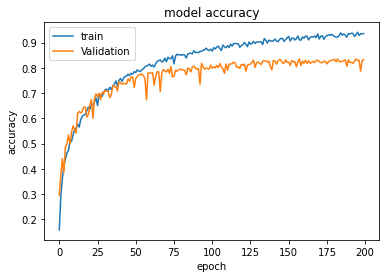

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model = load_model('/content/drive/MyDrive/building1/noWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl')

from sklearn.metrics import accuracy_score
y_pred=model.predict(test)
test_preds=( y_pred> 0.5).astype("int32")#Selecting a label only if it has >0.5 probability
accuracy_score(test_target, test_preds)

0.8239026063100137

In [ ]:
yhat=np.argmax(y_pred,axis=1)
y=np.argmax(test_target,axis=1)
accuracy_score(y,yhat)

0.8297325102880658

In [ ]:
#converting predicted labels to waypoins.
pred_df=pd.DataFrame(yhat,columns=['Label'])
label_df=pd.DataFrame(label,columns=['X_up_limit','Y_up_limit','Label'])
label_df.head()
pred_df2 = pd.merge(pred_df, label_df, on='Label', how='left')
pred_df2.head()

,Label,X_up_limit,Y_up_limit
0,78,214.213216,169.398780
1,79,233.944180,169.398780
2,78,214.213216,169.398780
3,79,233.944180,169.398780
4,69,233.944180,157.599565


In [ ]:
wp_pred=list()
#Adjust wp to centers
distx=(label[1][0]-label[0][0])/2
disty=(label[10][1]-label[0][1])/2 #for 10X10 grid
pred_df2['X_up_limit']=pred_df2['X_up_limit']-distx
pred_df2['Y_up_limit']=pred_df2['Y_up_limit']-disty
pred_df2.head()

,Label,X_up_limit,Y_up_limit
0,78,204.347734,163.499172
1,79,224.078698,163.499172
2,78,204.347734,163.499172
3,79,224.078698,163.499172
4,69,224.078698,151.699957


In [ ]:
#Now we will calculate exact error in predicted and actual location
#We will consider only those waypoints which were present in the original data
#to calculate error and we will reject interpolated values which were introduced by us 
import math
sum_of_error=0
sum_sq_error=0
count=0
test_predicted=pred_df2[['X_up_limit','Y_up_limit']].values
for i in range(len(test_seq_wp)):
  for j in range(len(test_seq_wp[i])):
    if(test_seq_wp[i][j][2]==1):
      sum_of_error+=math.sqrt(((test_predicted[i][0]-test_seq_wp[i][j][0])**2)+((test_predicted[i][1]-test_seq_wp[i][j][1])**2))
      sum_sq_error+=((test_predicted[i][0]-test_seq_wp[i][j][0])**2)+((test_predicted[i][1]-test_seq_wp[i][j][1])**2)
      count+=1


MAE=sum_of_error/count
RMSE=math.sqrt(sum_sq_error/count)
print('MAE value is:',round(MAE,2))  
print('RMSE value is:',round(RMSE,2)) 

MAE value is: 17.05
RMSE value is: 28.44
